# Transfer Learning DenseNet201 Pre-trained model TL_DN_M0



## 1. Importing and loading the preprocessed dataset

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


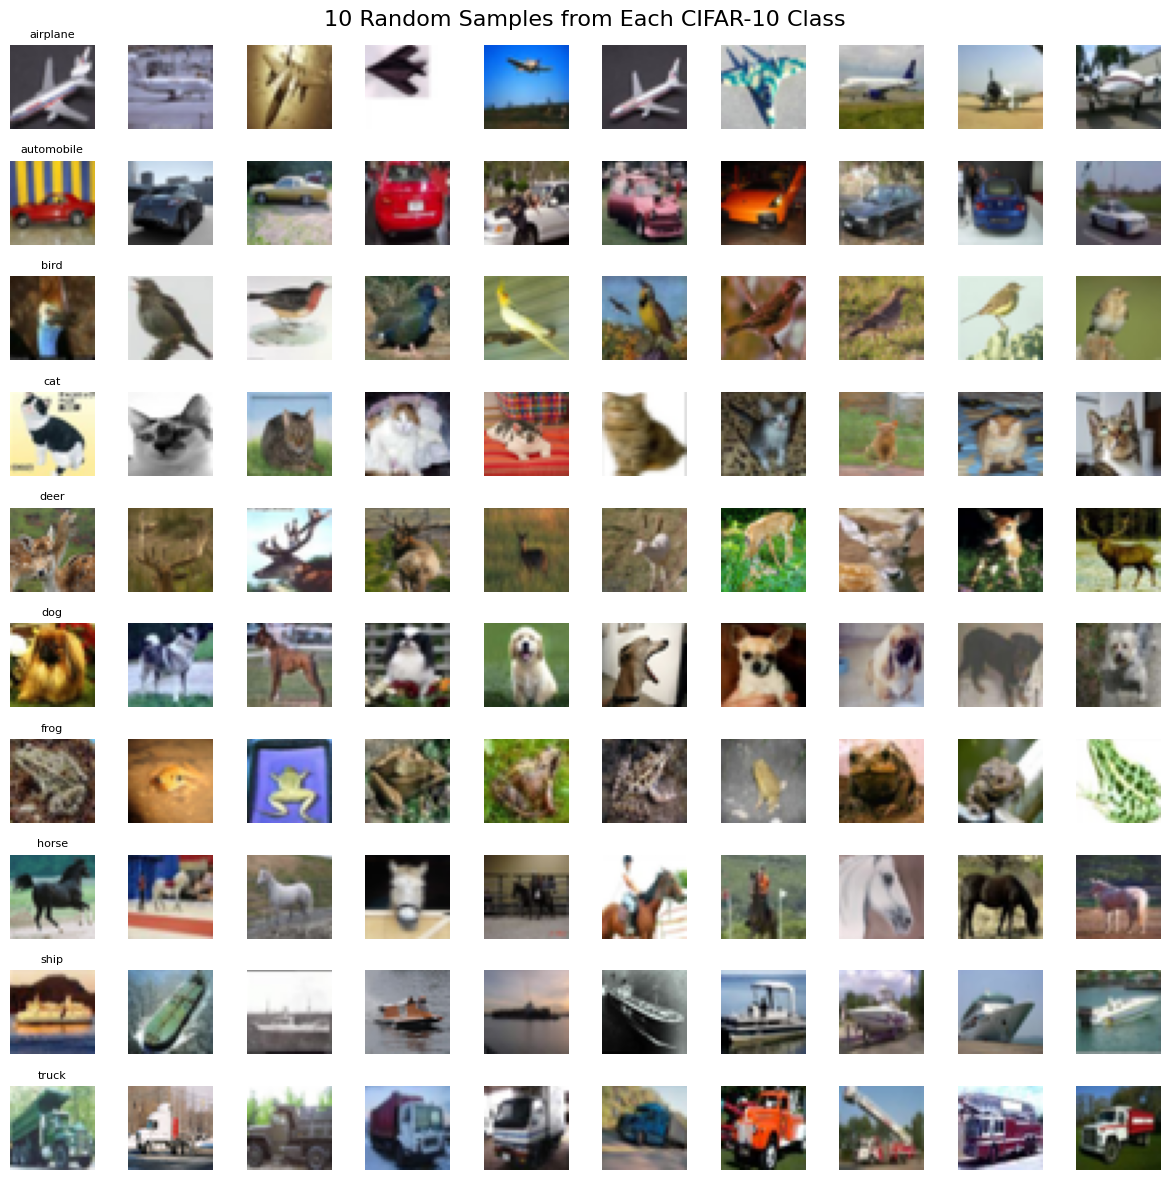

In [1]:
import nbformat
from IPython.core.interactiveshell import InteractiveShell

with open('preprocessing.ipynb') as f:
    nb = nbformat.read(f, as_version=4)

shell = InteractiveShell.instance()
for cell in nb.cells:
    if cell.cell_type == 'code':
        shell.run_cell(cell.source)

 ## 2. Model building

In [2]:
# First we will clear the keras session
from keras.backend import clear_session
clear_session()


#### 2.1 Loading the DenseNet201 pre-trained model from Keras

In [3]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import layers, models

# Load DenseNet201, excluding the top (classification) layers
base_model = DenseNet201(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False  # Freeze the pretrained weights initially

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#### 2.2 Creating training and testing datasets, for which we can apply image resizing

In [ ]:
import tensorflow as tf
# Setting image size to the input  shape of DenseNet201, so that we can re-size the images from CIFAR-10 data set.
IMG_SIZE = 224

# We create a tf.data.Dataset from our training and testing data, so that later we can appy map() to easily resize all images.
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# We define a function to resize images from CIFAR-10 dataset (32x32) to match the Densenet input size (224x224)
def resize_image(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image, label

# Apply the resizing function to the datasets, we've created
train_ds = train_ds.map(resize_image)
test_ds = test_ds.map(resize_image)

# We define the batch_size we want to use when fitting the model. Also, we use 'prefetch' method to speed up the training process.
batch_size = 64
train_ds = train_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

#### 2.3 Defining model architecture

We will use DenseNet201 as the base layer, followed by a pooling layer to reduce the tensor shape (GlobalAveragePooling2D). We have used GlobalAveragePooling2D beacuse, despite MaxPooling2D is great for downsampling and feature selection within the convolutional layers, GlobalAveragePooling2D is often preferred as the final pooling layer before classification because it provides a more robust and parameter-efficient way to summarize the extracted features across the entire image, reducing the risk of overfitting. 

Finally, on top of it we will add a Dense layer with Relu activation and 128 neurons, a dropout 0.5 layer and finally the output layer with softmax activation.

In [ ]:
model = models.Sequential([
    base_model,                                      # Pretrained feature extractor
    layers.GlobalAveragePooling2D(),                 # Reduce tensor shape
    layers.Dense(128, activation='relu'),            
    layers.Dropout(0.5),                             
    layers.Dense(10, activation='softmax')           
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       245,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,569,162 (70.84 MB)

 Trainable params: 247,178 (965.54 KB)

 Non-trainable params: 18,321,984 (69.89 MB)

## 3. Model training

#### 3.1 Compiling and training the model

In [ ]:

# Compiling the model using the defined parameters:

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train only the new classification head (all DenseNet201 layers frozen)
history = model.fit(train_ds, epochs=5, validation_data=test_ds)


Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 311s 330ms/step - accuracy: 0.6634 - loss: 0.9734 - val_accuracy: 0.8324 - val_loss: 0.4831
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 243s 269ms/step - accuracy: 0.8053 - loss: 0.5669 - val_accuracy: 0.8418 - val_loss: 0.4576
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 261s 269ms/step - accuracy: 0.8269 - loss: 0.5089 - val_accuracy: 0.8492 - val_loss: 0.4445
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 262s 269ms/step - accuracy: 0.8353 - loss: 0.4799 - val_accuracy: 0.8497 - val_loss: 0.4364
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 255s 260ms/step - accuracy: 0.8431 - loss: 0.4583 - val_accuracy: 0.8556 - val_loss: 0.4231


#### 3.2 Plot training history (loss/accuracy curves)

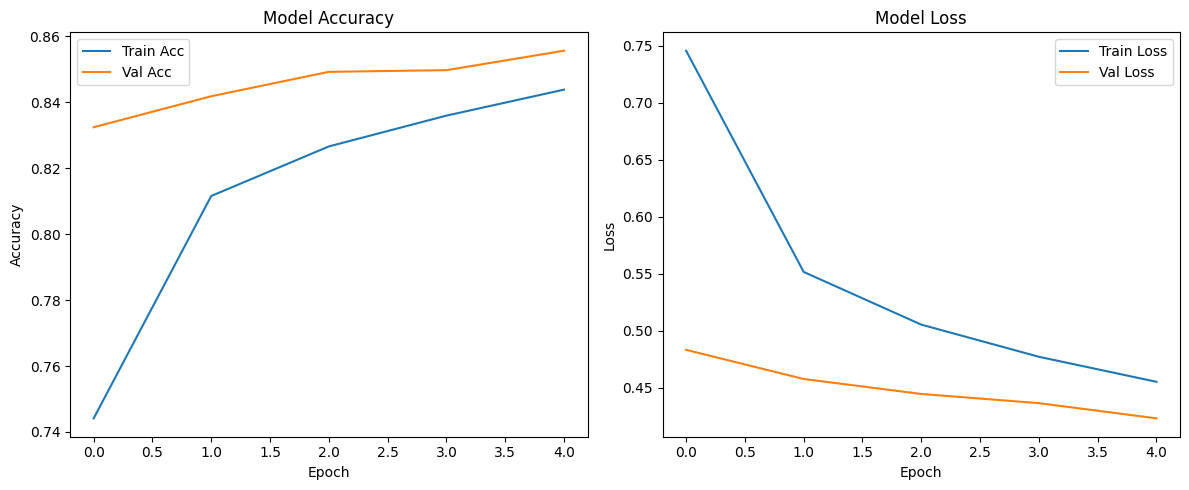

In [ ]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## 4. Model evaluation

#### 4.1 Evaluate on the test set

In [ ]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f'Test accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')

Test accuracy: 0.8556
Test loss: 0.4231


#### 4.2 Calculate metrics: Precision, recall, F1 score

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Get predictions from the model
y_pred = model.predict(test_ds)

# Convert one-hot encoded labels and predictions to class indices
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate precision, recall, and F1 score, using 'macro' average, as the classes are balanced (6k images per class)
precision = precision_score(y_test_classes, y_pred_classes, average='macro')
recall = recall_score(y_test_classes, y_pred_classes, average='macro')
f1 = f1_score(y_test_classes, y_pred_classes, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 54s 344ms/step
Precision: 0.8567
Recall: 0.8556
F1 Score: 0.8553


#### 4.3 Confusion matrix and classification report

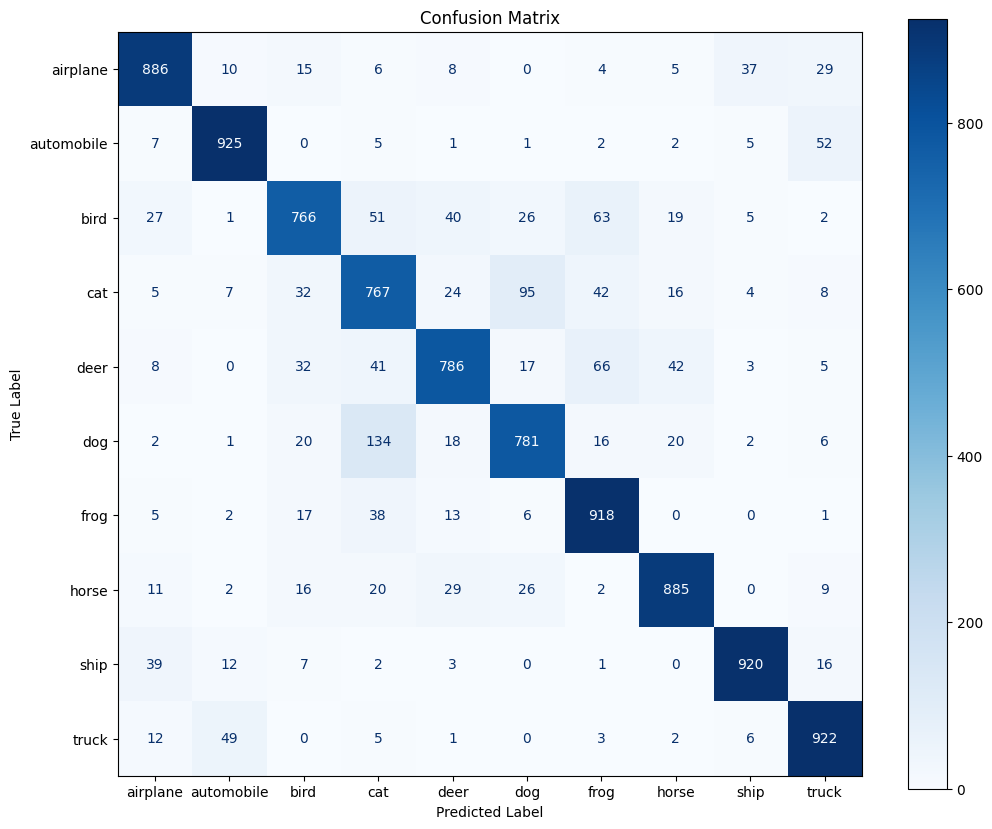

Classification Report:
              precision    recall  f1-score   support

    airplane       0.88      0.89      0.89      1000
  automobile       0.92      0.93      0.92      1000
        bird       0.85      0.77      0.80      1000
         cat       0.72      0.77      0.74      1000
        deer       0.85      0.79      0.82      1000
         dog       0.82      0.78      0.80      1000
        frog       0.82      0.92      0.87      1000
       horse       0.89      0.89      0.89      1000
        ship       0.94      0.92      0.93      1000
       truck       0.88      0.92      0.90      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(12, 10))
disp.plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))

## 5. Results and conclusion

We can observe that using a pre-trained model gives very accurate results, eventhough we've just executed 5 epochs. We've achieved an accuracy of 0.8556 and test_loss of 0.4231. This clearly improves the models in which we've trained the CNN model from scratch. In this case, we've frozen all the weights from the base model layers and just trained the output layer we've added.
In next iterations we are going to unfreeze some of the base model layers, and see if the accuracy improves.